In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

# load custom libraries
from generate_mission_profile import pnt2line, vector, path_segment

# set output folder
environment_folder = '../environments/baseline/'

# Developing the Mission Profile
We want a vector field for the uuv to travel in straight lines between waypoints.

The entire path will be generated at once.

A seperate vector field will be calculated for each waypoint.

## Geometry Setup
Global origin is in the bottom left corner (no negative coordinates).

In [2]:
# define the world grid
real_world_size = 2000  # world size in meters
real_world_resolution = 5  # spatial resolution in meters

x_spacing = real_world_resolution
y_spacing = real_world_resolution
max_x = ((real_world_size)/real_world_resolution) - 1
max_y = (real_world_size/real_world_resolution) - 1

world_x = np.linspace(0,max_x,int(max_x)+1)
world_y = np.linspace(0,max_y,int(max_y)+1)
world_X, world_Y = np.meshgrid(world_x, world_y)

world_z=[0]

world_dims = "0 %i 0 %i" % (max_x, max_y)

In [9]:
# use a basic grid
mine_cols = 10
mine_rows = 10
#mine_x_arr = np.linspace(mine_min_x, mine_max_x, mine_cols)
mine_x_arr = np.linspace(100, max_x-100, mine_cols) * real_world_resolution
mine_y_arr = np.linspace(100, max_y - 100, mine_rows) * real_world_resolution
mine_X, mine_Y = np.meshgrid(mine_x_arr, mine_y_arr)

minefield_df = pd.concat([pd.DataFrame(np.reshape(mine_X,(mine_X.size,1))), pd.DataFrame(np.reshape(mine_Y,(mine_Y.size,1)))], axis=1)
minefield_df = minefield_df.apply(lambda x: x/real_world_resolution)

In [4]:
# Define the waypoints of the mission in real world units (meters)
# TODO: generate this programatically
waypoints = [
    (200,10,0),
    (200,1800,0),
    (700,1800,0),
    (700,200,0),
    (1200,200,0),
    (1200,1800,0),
    (1700,1800,0),
    (1700,200,0),
    (200,10,0)
]

# normalize waypoints to NetLogo coordinates
waypoints_df = pd.DataFrame(waypoints).apply(lambda x: x/real_world_resolution)

In [5]:
# define obstacles
num_obstacles = 40
obs_matrix = np.random.random((num_obstacles,2))
obstacle_df = pd.DataFrame(obs_matrix * np.array((1350,real_world_size)) + np.array((600,0))).apply(lambda x: x/real_world_resolution)

Calculate the vector points based on the closest line point

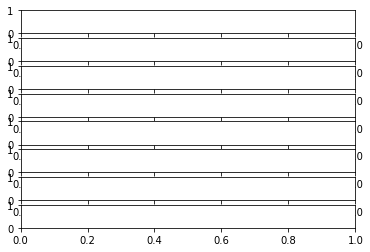

In [6]:
mission_leg = 0  # initialize mission leg counter
mission_array = []

# setup the plot
fig, axs = plt.subplots(len(waypoints)-1, 1)

# loop through each leg
while mission_leg < len(waypoints)-1:
    # define course correction field
    start_point = [ x/real_world_resolution for x in waypoints[mission_leg] ]  # normalize to NetLogo coordinates
    end_point = [ y/real_world_resolution for y in waypoints[mission_leg+1] ]  # normalize to NetLogo coordinates
    x_vec_array, y_vec_array = path_segment(start_point, end_point, world_x, world_y)
    
    # generate mission vector towards goal
    mission_vector = (np.array(end_point) - np.array(start_point))
    segment_length = np.sqrt(mission_vector[0]**2 + mission_vector[1]**2 + mission_vector[2]**2)
    
    mission_x = mission_vector[0]/segment_length
    mission_y = mission_vector[1]/segment_length
    mission_z = mission_vector[2]/segment_length
  
    mission_dx = mission_x * np.ones(world_X.shape)
    mission_dy = mission_y * np.ones(world_Y.shape)
    mission_dz = mission_z * np.ones(world_X.shape)

    # generate behavior vector field
    behavior_dx = mission_dx + x_vec_array
    behavior_dy = mission_dy + y_vec_array
    behavior_dz = np.zeros(behavior_dx.shape)  # no movement in z dimension

    # create pandas dataframe out of the reshaped arrays to feed into NetLogo
    patch_data = pd.concat([pd.DataFrame(np.reshape(world_X,(world_X.size,1))), 
                            pd.DataFrame(np.reshape(world_Y,(world_Y.size,1))),
                            pd.DataFrame(np.reshape(behavior_dx,(behavior_dx.size,1))), 
                            pd.DataFrame(np.reshape(behavior_dy,(behavior_dy.size,1)))], 
                           axis=1)
    # mission_array.append(patch_data)
    patch_data.to_csv(environment_folder + 'mission_leg_' + str(mission_leg) + '.txt', index=False, header=False, sep=' ')
    
    mission_leg += 1
    
# plt.show()

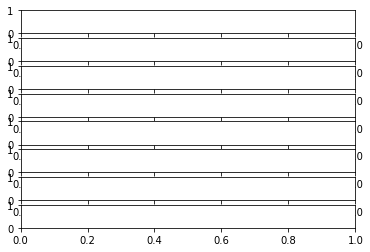

In [7]:
mission_leg = 0  # initialize mission leg counter
mission_df = pd.DataFrame(pd.Series(np.reshape(world_X,(world_X.size,1))[:,0]))
mission_df = pd.concat([mission_df, pd.Series(np.reshape(world_Y,(world_Y.size,1))[:,0])], axis=1)

# setup the plot
fig, axs = plt.subplots(len(waypoints)-1, 1)

# loop through each leg
while mission_leg < len(waypoints)-1:
    # define course correction field
    start_point = [ x/real_world_resolution for x in waypoints[mission_leg] ]  # normalize to NetLogo coordinates
    end_point = [ y/real_world_resolution for y in waypoints[mission_leg+1] ]  # normalize to NetLogo coordinates
    x_vec_array, y_vec_array = path_segment(start_point, end_point, world_x, world_y)
    
    # generate mission vector towards goal
    mission_vector = (np.array(end_point) - np.array(start_point))
    segment_length = np.sqrt(mission_vector[0]**2 + mission_vector[1]**2 + mission_vector[2]**2)
    
    mission_x = mission_vector[0]/segment_length
    mission_y = mission_vector[1]/segment_length
    mission_z = mission_vector[2]/segment_length
  
    mission_dx = mission_x * np.ones(world_X.shape)
    mission_dy = mission_y * np.ones(world_Y.shape)
    mission_dz = mission_z * np.ones(world_X.shape)

    # generate behavior vector field
    behavior_dx = mission_dx + x_vec_array
    behavior_dy = mission_dy + y_vec_array
    behavior_dz = np.zeros(behavior_dx.shape)  # no movement in z dimension

    # create pandas dataframe out of the reshaped arrays to feed into NetLogo
    patch_data = pd.concat([pd.DataFrame(np.reshape(behavior_dx,(behavior_dx.size,1))), 
                            pd.DataFrame(np.reshape(behavior_dy,(behavior_dy.size,1)))], 
                           axis=1)
    mission_df = pd.concat([mission_df, patch_data], axis=1)
    
    mission_leg += 1
    
# plt.show()

In [8]:
# write environment setup files

with open(environment_folder + "world_dims.txt", "w") as dims_file:
    print(world_dims, file=dims_file)

mission_df.to_csv(environment_folder + 'mission_profile' + '.txt', index=False, header=False, sep=' ')
    
waypoints_df.to_csv(environment_folder + 'mission_waypoints.txt', index=True, header=False, sep=' ')

minefield_df.to_csv(environment_folder + 'minefield.txt', index=False, header=False, sep=' ')

obstacle_df.to_csv(environment_folder + 'obstacles.txt', index=False, header=False, sep=' ')

In [31]:
patch_data.head()

,0,0,0,0
0,0.0,0.0,250.0,-1.0
1,1.0,0.0,249.0,-1.0
2,2.0,0.0,248.0,-1.0
3,3.0,0.0,247.0,-1.0
4,4.0,0.0,246.0,-1.0


In [32]:
len(world_x)

500

In [15]:
np.random.random((5,2)) * np.array((100, 5))

array([[ 66.65855689,   4.42940496],
       [  5.7941373 ,   3.92744429],
       [ 37.85274429,   3.95019825],
       [ 50.01641302,   2.49207716],
       [ 68.60788469,   4.04142223]])

In [18]:
np.array((0,5)) + np.random.random((5,2))

array([[ 0.09673286,  5.86922292],
       [ 0.06823751,  5.85941137],
       [ 0.6002404 ,  5.02662883],
       [ 0.76176984,  5.31106916],
       [ 0.69975121,  5.03466148]])

In [5]:
minefield_df.to_csv(environment_folder + 'minefield_1.txt', index=False, header=False, sep=' ')

In [10]:
minefield_df.to_csv(environment_folder + 'minefield.txt', index=False, header=False, sep=' ')

In [23]:
pd.DataFrame([pd.DataFrame(np.reshape(world_X,(world_X.size,1))), 
                            pd.DataFrame(np.reshape(world_Y,(world_Y.size,1)))])

ValueError: Must pass 2-d input

In [54]:
df = pd.DataFrame(pd.Series(np.reshape(world_X,(world_X.size,1))[:,0]))
pd.concat([df, pd.Series(np.reshape(world_Y,(world_Y.size,1))[:,0])], axis=1)

,0,0
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,4.0,0.0
5,5.0,0.0
6,6.0,0.0
7,7.0,0.0
8,8.0,0.0
9,9.0,0.0
